# Notebook for the Inventory Management Problem
## Attack detection

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import scipy.stats as stats
from collections import deque
from inventory import Inventory
from attacker import *
from utils import *
from matplotlib.patches import Patch
from matplotlib.lines import Line2D

In [2]:
SMALL_SIZE = 12
MEDIUM_SIZE = 14
BIGGER_SIZE = 18
plt.rcParams.update({
    "font.family": "serif",  # use serif/main font for text elements
    "text.usetex": True,  # use inline math for ticks
    "pgf.rcfonts": False,  # don't setup fonts from rc parameters
    "legend.fontsize": 14})
plt.rcParams['pgf.preamble'] = r"\\usepackage{units} \\usepackage{amsmath} \\usepackage{metalogo} \\usepackage{unicode-math} \\setmainfont{DejaVu Serif} \\setmathfont{xits-math.otf}"
plt.rc('font', size=BIGGER_SIZE)          # controls default text sizes
plt.rc('axes', titlesize=BIGGER_SIZE)     # fontsize of the axes title
plt.rc('axes', labelsize=BIGGER_SIZE)    # fontsize of the x and y labels
plt.rc('xtick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
plt.rc('ytick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
plt.rc('legend', fontsize=BIGGER_SIZE)    # legend fontsize
plt.rc('figure', titlesize=BIGGER_SIZE)  # fontsize of the figure title

## Setup problem

In [3]:
inventory_size = 35
gamma = 0.95
env = Inventory(inventory_size)
dim_state, dim_action = env.P.shape[0], env.P.shape[1]
V, pi = value_iteration(env, gamma)

In [4]:
eps_det = 3
eps_rn = 0.21
beta = 6.2
alpha = [0.] * env.P.shape[0]
alpha[-1] = 1
v_det, phi_det, mud = compute_deterministic_attack(gamma, 0., env.P, -env.R, pi, lambda x,y: np.abs(x-y) <= eps_det, alpha)
v_det2, phi_det2, mud = compute_deterministic_attack(gamma, beta, env.P, -env.R, pi, lambda x,y: True, alpha)
v_rnd, phi_rnd, mud = compute_randomized_attack(gamma, eps_rn, env.P, -env.R, pi, alpha)

### Functions used to perform the simulations

In [5]:
class GLR(object):
    def __init__(self, dim_state, dim_action, P, size=100):
        self.visits = np.ones((dim_state, dim_action, dim_state))
        x = np.arange(dim_state)
        self.P = np.copy(P)
        self.experiences = []
        self.size = size
        
    def update(self, x, a, next_x):
        self.experiences.append([x, a, next_x])
        self.visits[x, a, next_x] += 1
        if len(self.experiences) > self.size:
            x, a, next_x = self.experiences.pop(0)
            self.visits[x, a, next_x] -= 1
        return self.compute_llr()
    
    def compute_llr(self):
        P = self.visits/self.visits.sum(axis=-1, keepdims=True)
        Z = 0
        for x, a, next_x in self.experiences:
            Z += np.log(P[x, a, next_x] / self.P[x, a, next_x])
        return Z
        


def run_episode(env, max_steps, pi, phi, attack_time):
    state = env.reset()
    episode_reward = 0
    cusum_stats = [0.]
    glr_stats = [0.]
    states = [state]
    actions = []
    dim_state, dim_action = env.P.shape[0], env.P.shape[1]
    
    detector_sizes = np.arange(10, max_steps, 5) # [10, 20, 30, 50, 70, 100]#, 50, 100, 150]
    glrs = [GLR(dim_state, dim_action, env.P, size=x) for x in detector_sizes]
    
    # TO reach stationarity
    for t in range(25):
        action = np.random.choice(dim_action, p=pi[state])
        state, reward = env.step(action)
    
    for t in range(max_steps):
        action = np.random.choice(dim_action, p=pi[state])
        original_action = action
        if t >= attack_time:
            action = np.random.choice(dim_action, p=phi[state])
        actions.append(action)
        next_state, reward = env.step(action)
        episode_reward += reward
        lr = np.dot(phi[state], env.P[state, :, next_state]).item() / env.P[state, original_action, next_state]
        lr = lr if not np.isclose(lr, 0.) else 1
        cusum_stats.append(max(0, cusum_stats[-1]) + np.log(lr))
        
        G = 0
        for glr in glrs:
            Z = glr.update(state, original_action, next_state)
            if Z > G:
                G = Z
        glr_stats.append(G)
        state = next_state
        states.append(state)
        

    return episode_reward, cusum_stats, states, actions, glr_stats
#_, _, _, _, glr = run_episode(env, 200, pi, phi_det, 50)

## Run simulations

In [6]:
n_simulations = 100
n_steps = 150
attack_time = 0

cusum_stats = np.zeros((3, n_simulations, n_steps + 1))
glr_stats = np.zeros((3, n_simulations, n_steps + 1))
for idx, phi in enumerate([phi_det, phi_det2, phi_rnd]):
    for n in range(n_simulations):
        ep_reward, cusum, states, actions, glr = run_episode(env, n_steps, pi, phi, attack_time)
        cusum_stats[idx, n] = cusum
        glr_stats[idx, n] = glr


## Plot results

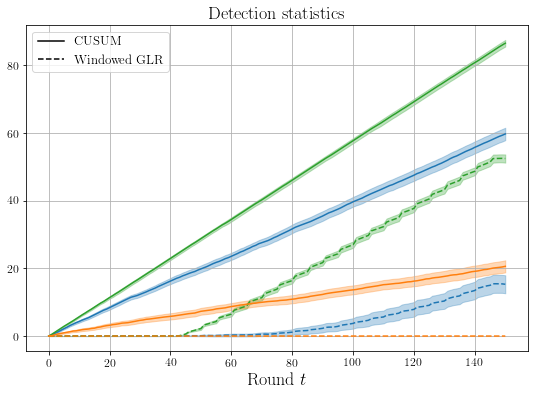

In [7]:
cusum_mean = cusum_stats.mean(axis=1)
cusum_std = cusum_stats.std(axis=1)
cusum_ci = 3 * cusum_std/ np.sqrt(n_simulations)

glr_mean = glr_stats.mean(axis=1)
glr_std = glr_stats.std(axis=1)
glr_ci = 3 * glr_std/ np.sqrt(n_simulations)
colors = ['C0','C2', 'C1']
fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(9, 6))

for idx, phi in enumerate([phi_det, phi_det2, phi_rnd]):
    ax.plot(range(n_steps + 1), cusum_mean[idx], color=colors[idx])
    ax.fill_between(range(n_steps + 1), (cusum_mean[idx]-cusum_ci[idx]), (cusum_mean[idx]+cusum_ci[idx]),  alpha=.3, color=colors[idx])
    
    ax.plot(range(n_steps + 1), glr_mean[idx], '--', color=colors[idx])
    ax.fill_between(range(n_steps + 1), (glr_mean[idx]-glr_ci[idx]), (glr_mean[idx]+glr_ci[idx]),  alpha=.3, color=colors[idx])

    
legend_elements = [
    Line2D([0], [0], color='k', linestyle='-', label='CUSUM'),
    Line2D([0], [0], color='k', linestyle='--', label='Windowed GLR'),
]


ax.set_xlabel(r'Round $t$')
ax.set_title('Detection statistics')
plt.legend(handles=legend_elements, fontsize=13)
plt.grid()
plt.savefig("inventory_attack_detection_final.pdf",bbox_inches="tight")
plt.show()

## Save results

In [8]:
import pickle

data = {'cusum': cusum_stats,
     'glr': glr_stats,
      'n_steps': n_steps,
       'n_simulations': n_simulations,
       'phi': [phi_det, phi_det2, phi_rnd]}

with open('data_detection.pkl', 'wb') as handle:
    pickle.dump(data, handle)
